In [1]:
# Данные тут
# https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime

import tscv

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import r2_score, mean_absolute_percentage_error


In [2]:
temp=pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv')
display(temp.head(3))
temp.info()

,Date,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
0,11/01/2019 12:00:00 AM,12.0,7.0,5.0
1,11/01/2019 01:00:00 AM,7.0,0.0,7.0
2,11/01/2019 02:00:00 AM,1.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141422 entries, 0 to 141421
Data columns (total 4 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Date                          141422 non-null  object 
 1   Fremont Bridge Total          141400 non-null  float64
 2   Fremont Bridge East Sidewalk  141400 non-null  float64
 3   Fremont Bridge West Sidewalk  141400 non-null  float64
dtypes: float64(3), object(1)
memory usage: 4.3+ MB


In [3]:
df = pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv',
                 index_col='Date', 
                 parse_dates = True).sort_index()

df = df[~df.index.duplicated(keep='last')]
df = df.dropna()
df = df.drop(['Fremont Bridge East Sidewalk','Fremont Bridge West Sidewalk'],axis=1)
df.head()

,Fremont Bridge Total
Date,
2012-10-03 00:00:00,13.0
2012-10-03 01:00:00,10.0
2012-10-03 02:00:00,2.0
2012-10-03 03:00:00,5.0
2012-10-03 04:00:00,7.0


In [4]:
# Собираем датасет, гарантировано с шагом 1 час и заполнением пропусков целыми числами,
# важно убедится в отсутствии отрицательных значений

data = df.resample('60min').asfreq().interpolate(method='piecewise_polynomial').astype('int')
data['Date_time'] = data.index.to_pydatetime()
data.columns = ['Total','Date_time']
data.head()

,Total,Date_time
Date,,
2012-10-03 00:00:00,13,2012-10-03 00:00:00
2012-10-03 01:00:00,10,2012-10-03 01:00:00
2012-10-03 02:00:00,2,2012-10-03 02:00:00
2012-10-03 03:00:00,5,2012-10-03 03:00:00
2012-10-03 04:00:00,7,2012-10-03 04:00:00


## Рассмотрим примеры валидации `tscv`

In [5]:
data_split = data['2019-07':'2019-09']
data_split

X = data_split['Date_time']
y = data_split['Total']

gap_size = 50
X_train, X_test, y_train, y_test = tscv.gap_train_test_split(X, y, test_size = 0.25, gap_size=gap_size)

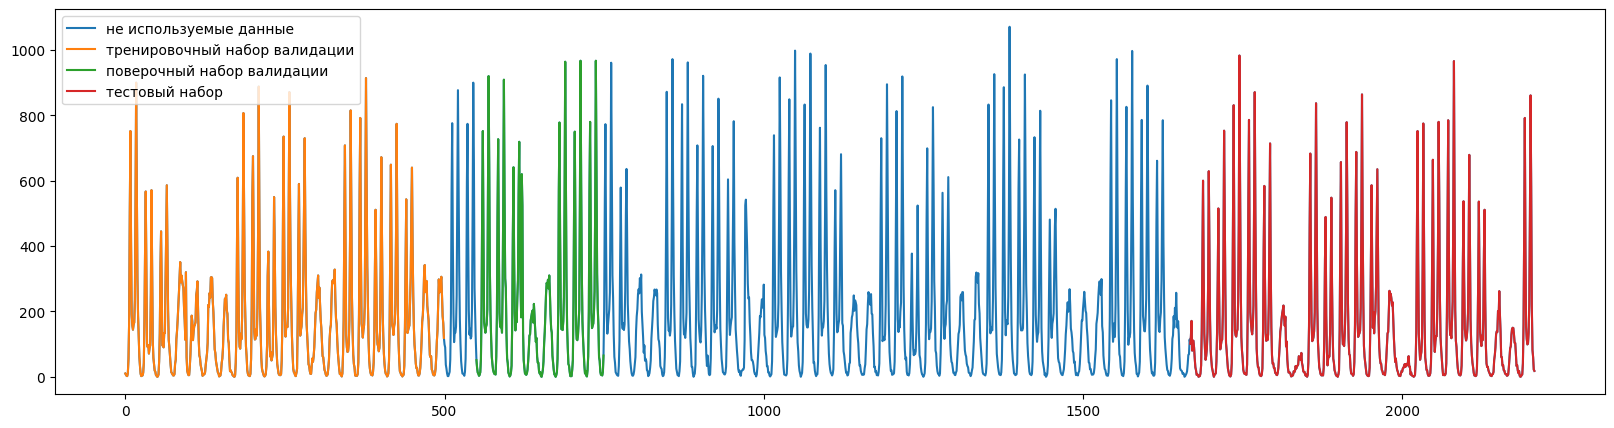

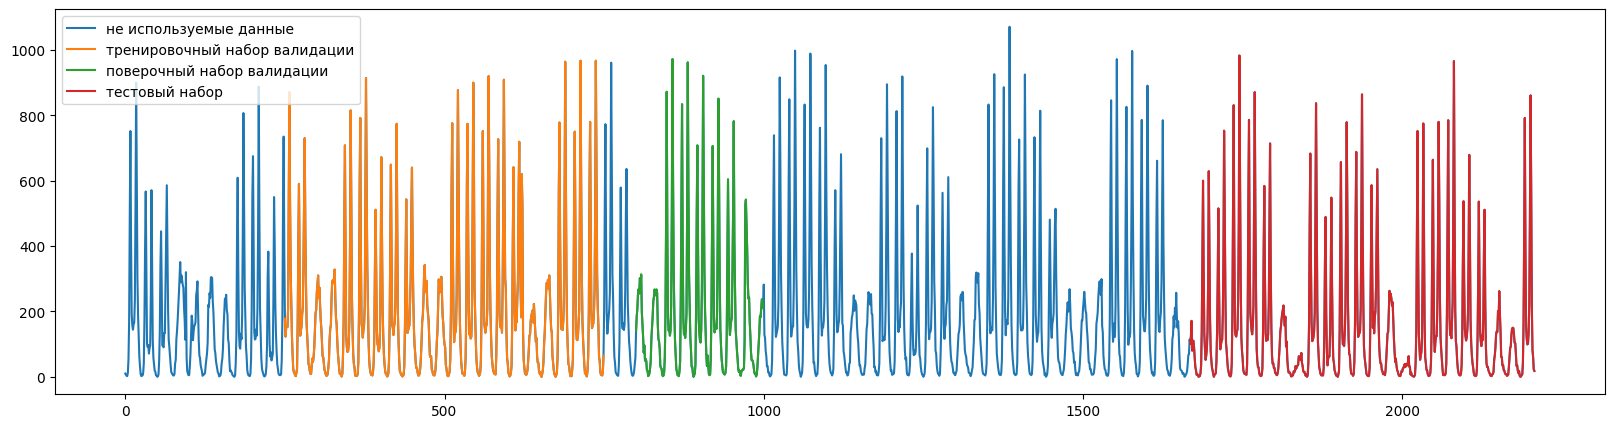

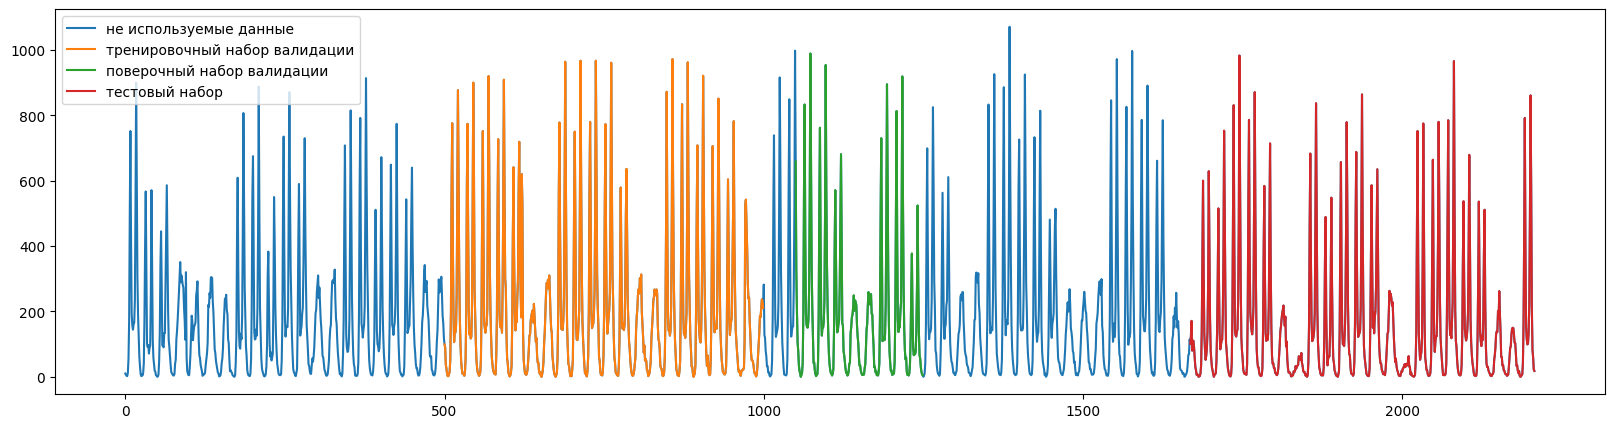

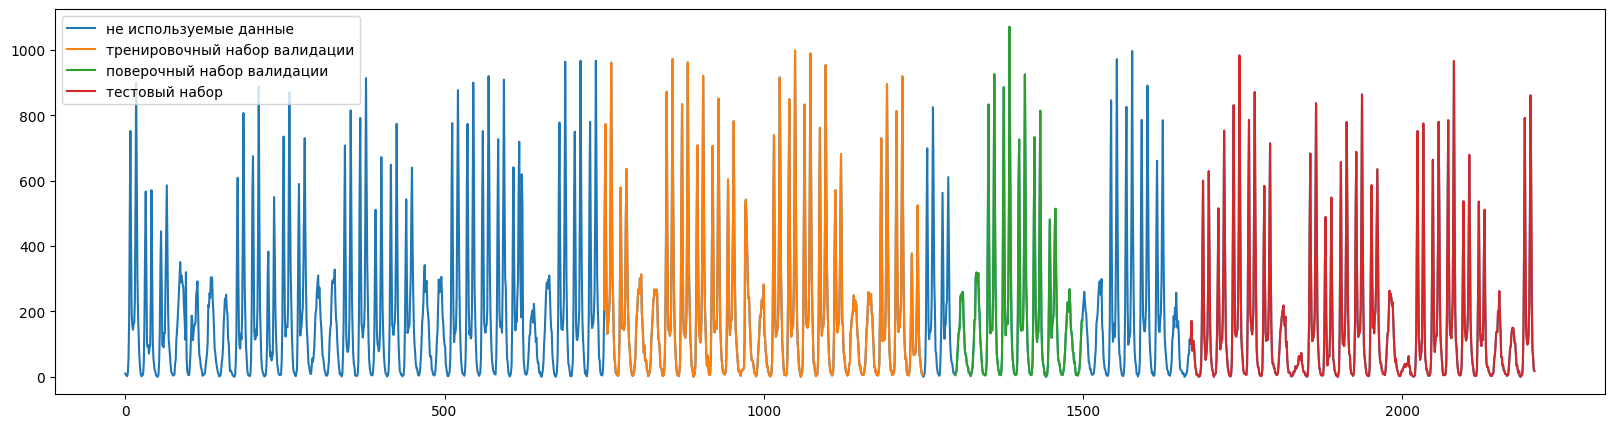

In [6]:
##### ------------------ ####
cv_GapKFold = tscv.GapKFold( n_splits=3, gap_before= 50, gap_after=50)
##### ------------------ ####
cv_GapWalkForward = tscv.GapWalkForward(
    n_splits = 3,
    max_train_size = 400,
    test_size = 100,
    gap_size = 50)

##### ------------------ ####
cv_GapRollForward = tscv.GapRollForward(
        min_train_size=500, 
        max_train_size=500,
        min_test_size=200, 
        max_test_size=200,
        gap_size=50, 
        roll_size=250)
##### ------------------ ####

cv = cv_GapRollForward

##### ------------------ ####

all_splits = list(cv.split(X_train, y_train))
lst = range(len(list(all_splits)))
ran = range(len(y_train))

for i in lst:
    train_sp, test_sp = all_splits[i]
    df_tmp = pd.DataFrame(index = ran, data = {'1': ran, '2':np.nan}) # избегаем
    df_tmp.iloc[df_tmp[~df_tmp.index.isin(train_sp)].index, 0] = np.nan       # гэпов по оси x
    df_tmp.iloc[train_sp , 1] = y_train[train_sp]                     #
    train_sp = df_tmp['1'].values                                     #
    plt.figure(figsize=(20, 5))
    plt.plot(range(len(y)), y, label='не используемые данные')
    plt.plot(train_sp, y_train, label='тренировочный набор валидации');
    plt.plot(test_sp, y_train[test_sp], label='поверочный набор валидации')
    plt.plot(range(len(y_train)+gap_size, len(y_train)+gap_size+len(y_test)), y_test, label='тестовый набор')
    plt.legend()
    plt.show()

## Начнем собирать модель

### Делим набор на тест и тренировку

In [7]:
data_tscv = data['2019-07':'2019-09']

gap_size = 3*24

X = data_split['Date_time']
y = data_split['Total']

X_train, X_test, y_train, y_test = tscv.gap_train_test_split(
                data_tscv.index.to_pydatetime().reshape(-1,1), 
                data_tscv['Total'], 
                test_size = 0.25, 
                gap_size=gap_size)

### Делим набор на тест и тренировку

In [8]:
cv = tscv.GapKFold(n_splits=5, gap_before= 24*3, gap_after=24*3)
all_splits = list(cv.split(X_train, y_train)) # сохраним сплиты тренировочного набора

### Нужные функции

функция оценки модели по MAE и MSE на валидации

In [9]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    print(
        f"Mean Absolute Error (MAE):     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error (RMSE): {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
        f"R^2 : {r2.mean():.3f} +/- {r2.std():.3f}"
    )

трансформер для даты времени

In [10]:
def transform_time_hour(X):
    """Конвектор datetime  в числовой формат"""
    return pd.DataFrame(X).apply(lambda x: pd.DatetimeIndex(x).hour)

def transform_time(tmp='hour'):
    """Универсальеый конвектор datetime  в числовой формат"""
    """код пишет сам себя :)"""
    return eval('FunctionTransformer(lambda X: pd.DataFrame(X).apply(lambda x: \
                pd.DatetimeIndex(x).'+tmp+'))')


In [11]:
transform_time_hour([
    [datetime.datetime(2019, 7, 1, 0, 0)],
    [datetime.datetime(2019, 7, 1, 1, 0)]
])

,0
0,0
1,1


## Построим простую модель

Mean Absolute Error (MAE):     40.978 +/- 6.696
Root Mean Squared Error (RMSE): 75.762 +/- 15.109
R^2 : 0.850 +/- 0.090


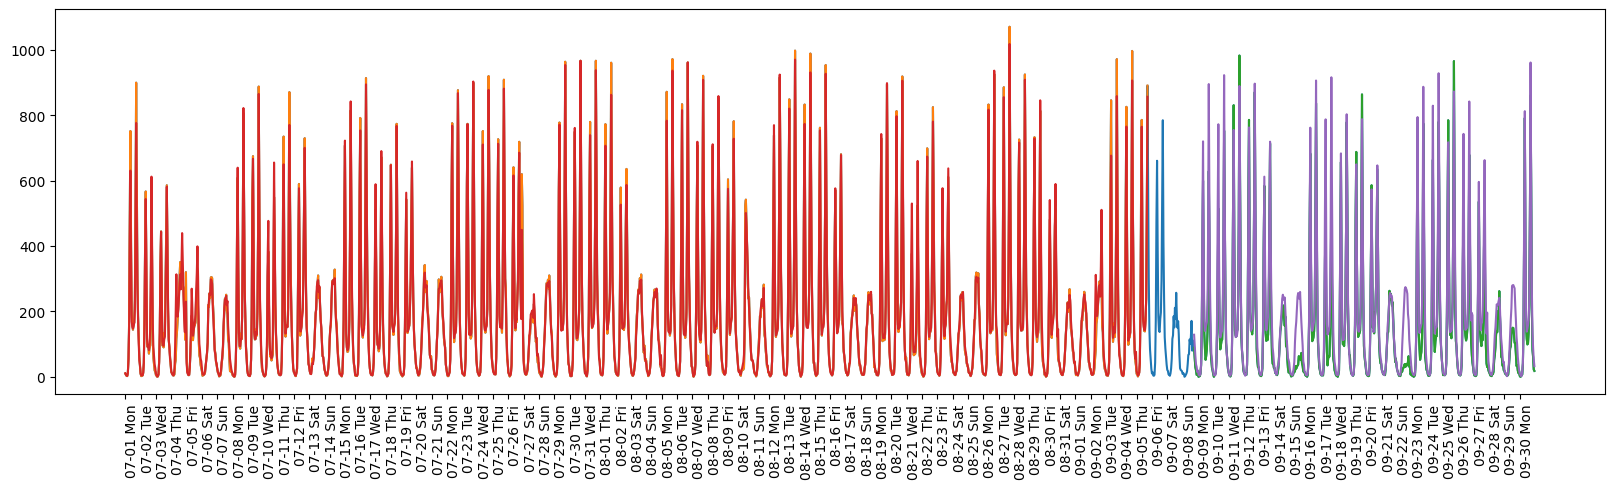

In [12]:
ct = ColumnTransformer(
    [
     ("hour",  transform_time('hour'),[0]),
     ("day",   transform_time('day'),[0]),
     ("week",  transform_time('weekday'),[0]),
     ("month", transform_time('month'),[0])
    ])

pipe_1 = make_pipeline(ct, RandomForestRegressor(n_estimators=100))
pipe_1.fit(X_train, y_train)

evaluate(pipe_1, X_train, y_train, cv)

pipe_1.fit(X_train, y_train)
y_train_predict = pipe_1.predict(X_train)
y_predict = pipe_1.predict(X_test)


plt.figure(figsize=(20, 5))

### исходные данные

xticks = pd.date_range(start = data_tscv.index.min(), end=data_tscv.index.max(),freq='D')
x_range = [data_tscv.index.get_loc(t) for t in xticks]

plt.xticks(x_range, xticks.strftime("%m-%d %a"), rotation=90, ha="left")

# все истина
plt.plot(range(len(X)), y, label="all")
# тренировка истина
plt.plot(range(len(X_train)), y_train, label="train")
# тест истина
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_test, label="train");

# тренировка predict
plt.plot(range(len(X_train)), y_train_predict, label="train predict")

# тренировка predict
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_predict, label="predict");

In [13]:
print(X_train)
ct.fit_transform(X_train)


[[datetime.datetime(2019, 7, 1, 0, 0)]
 [datetime.datetime(2019, 7, 1, 1, 0)]
 [datetime.datetime(2019, 7, 1, 2, 0)]
 ...
 [datetime.datetime(2019, 9, 5, 15, 0)]
 [datetime.datetime(2019, 9, 5, 16, 0)]
 [datetime.datetime(2019, 9, 5, 17, 0)]]


array([[ 0,  1,  0,  7],
       [ 1,  1,  0,  7],
       [ 2,  1,  0,  7],
       ...,
       [15,  5,  3,  9],
       [16,  5,  3,  9],
       [17,  5,  3,  9]])

## Попытка построения еще более "простой" класической модели

In [14]:
## Время должно быть переведено в "удобный" формат
## Внимание astype теперь не работает

dfb = df['2019-07':'2019-09']

X_t = dfb.index.view(int)// 10**10
X = X_t.reshape(-1,1)
y = dfb['Fremont Bridge Total'].values

display(X)

X_train, X_test, y_train, y_test = tscv.gap_train_test_split(
                X, y, 
                test_size = 0.25, 
                gap_size=gap_size)

array([[156193920],
       [156194280],
       [156194640],
       ...,
       [156987720],
       [156988080],
       [156988440]])

In [15]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
scores = cross_val_score(regressor, X_train, y_train, cv=cv)

print("R^2 тренировок:  ", scores)
print("средний R^2 тренировок:  ", scores.mean())

R^2 тренировок:   [-0.36101895 -2.61220186 -3.26343247 -0.35930816 -2.3632802 ]
средний R^2 тренировок:   -1.7918483254655115


In [16]:
regressor.fit(X_train, y_train)
y_train_predict = regressor.predict(X_train)
y_predict = regressor.predict(X_test)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("R^2 :  ", r2_score(y_test, y_predict))
print("MSE :  ", mean_squared_error(y_test, y_predict, squared = False))  # не путать MSE и RMSE

R^2 :   -9.624392921371403
MSE :   631.7834207614693


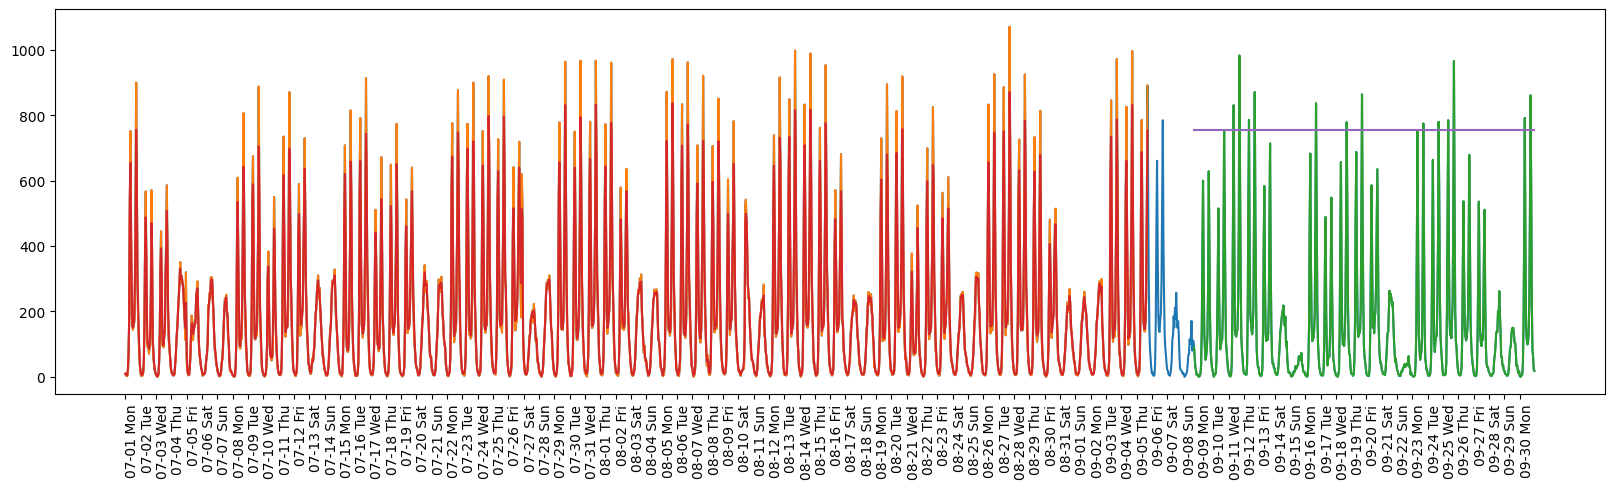

In [17]:
plt.figure(figsize=(20, 5))

### исходные данные

xticks = pd.date_range(start = dfb.index.min(), end=dfb.index.max(),freq='D')
x_range = [dfb.index.get_loc(t) for t in xticks]

plt.xticks(x_range, xticks.strftime("%m-%d %a"), rotation=90, ha="left")

# все истина
plt.plot(range(len(X)), y, label="all")
# тренировка истина
plt.plot(range(len(X_train)), y_train, label="train")
# тест истина
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_test, label="train");

# тренировка predict
plt.plot(range(len(X_train)), y_train_predict, label="train predict")

# тренировка predict
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_predict, label="predict");

## Попытка усложним модель, добавим час и день недели

In [18]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    print(
        f"Mean Absolute Error (MAE):     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error (RMSE): {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
        f"R^2 : {r2.mean():.3f} +/- {r2.std():.3f}"
    )

In [19]:
dfc = dfb.copy()
dfc['time_index'] = dfc.index.view(int)// 10**10
dfc['hour'] = dfc.index.hour
dfc['dayofweek'] = dfc.index.dayofweek

display( dfc.head() )

,Fremont Bridge Total,time_index,hour,dayofweek
Date,,,,
2019-07-01 00:00:00,10.0,156193920,0,0
2019-07-01 01:00:00,6.0,156194280,1,0
2019-07-01 02:00:00,3.0,156194640,2,0
2019-07-01 03:00:00,2.0,156195000,3,0
2019-07-01 04:00:00,12.0,156195360,4,0


In [20]:
X = dfc.iloc[:,1:].values
y = dfc['Fremont Bridge Total'].values

In [21]:
gap_size = 3*23
X_train, X_test, y_train, y_test = tscv.gap_train_test_split(X, y, test_size = 0.25, gap_size = gap_size)

In [22]:
cv = tscv.GapKFold( n_splits=5, gap_before= 3*23, gap_after=3*23)

In [23]:
forest = RandomForestRegressor(n_estimators=300, random_state=42)
evaluate(forest, X=X_train, y=y_train, cv=cv)
forest.fit(X_train, y_train)
y_train_predict = forest.predict(X_train)
y_predict = forest.predict(X_test)

Mean Absolute Error (MAE):     30.494 +/- 9.400
Root Mean Squared Error (RMSE): 60.099 +/- 19.701
R^2 : 0.899 +/- 0.067


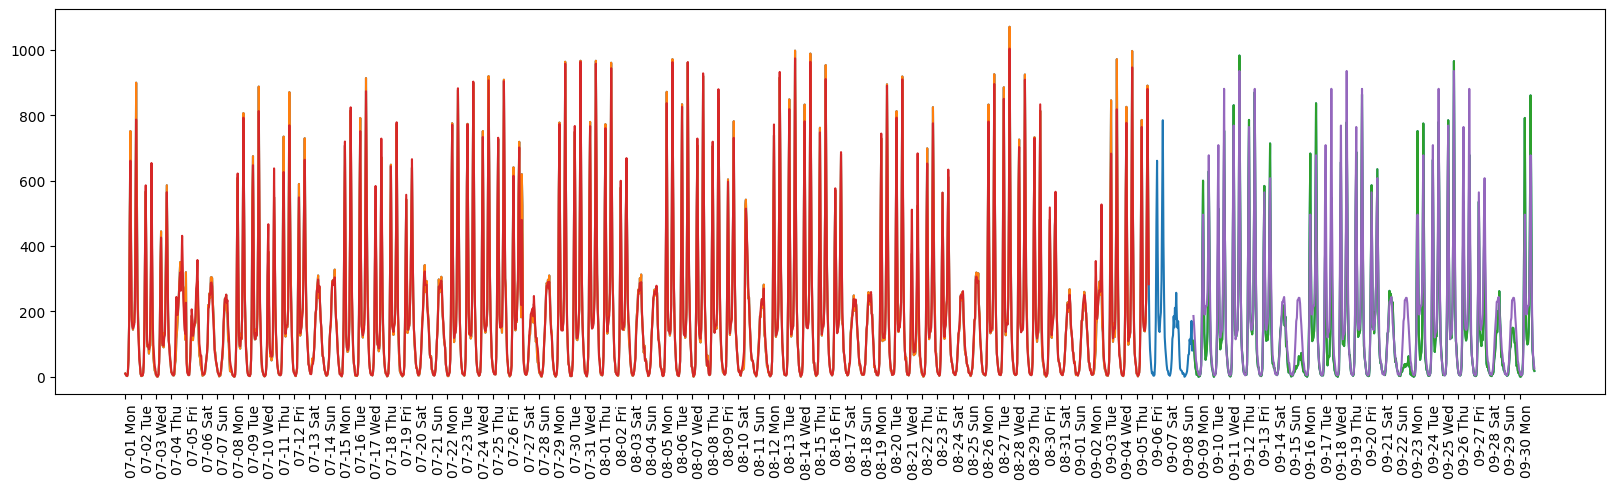

In [24]:
plt.figure(figsize=(20, 5))

### исходные данные

xticks = pd.date_range(start = dfc.index.min(), end=dfb.index.max(),freq='D')
x_range = [dfc.index.get_loc(t) for t in xticks]

plt.xticks(x_range, xticks.strftime("%m-%d %a"), rotation=90, ha="left")

# все истина
plt.plot(range(len(X)), y, label="all")
# тренировка истина
plt.plot(range(len(X_train)), y_train, label="train")
# тест истина
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_test, label="train");

# тренировка predict
plt.plot(range(len(X_train)), y_train_predict, label="train predict")

# тренировка predict
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_predict, label="predict");

In [25]:
gb =  GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate(gb, X = X_train, y = y_train, cv=cv)
gb.fit(X_train,y_train)
y_train_predict = gb.predict(X_train)
y_predict = gb.predict(X_test)

Mean Absolute Error (MAE):     49.929 +/- 13.731
Root Mean Squared Error (RMSE): 72.897 +/- 14.447
R^2 : 0.861 +/- 0.083


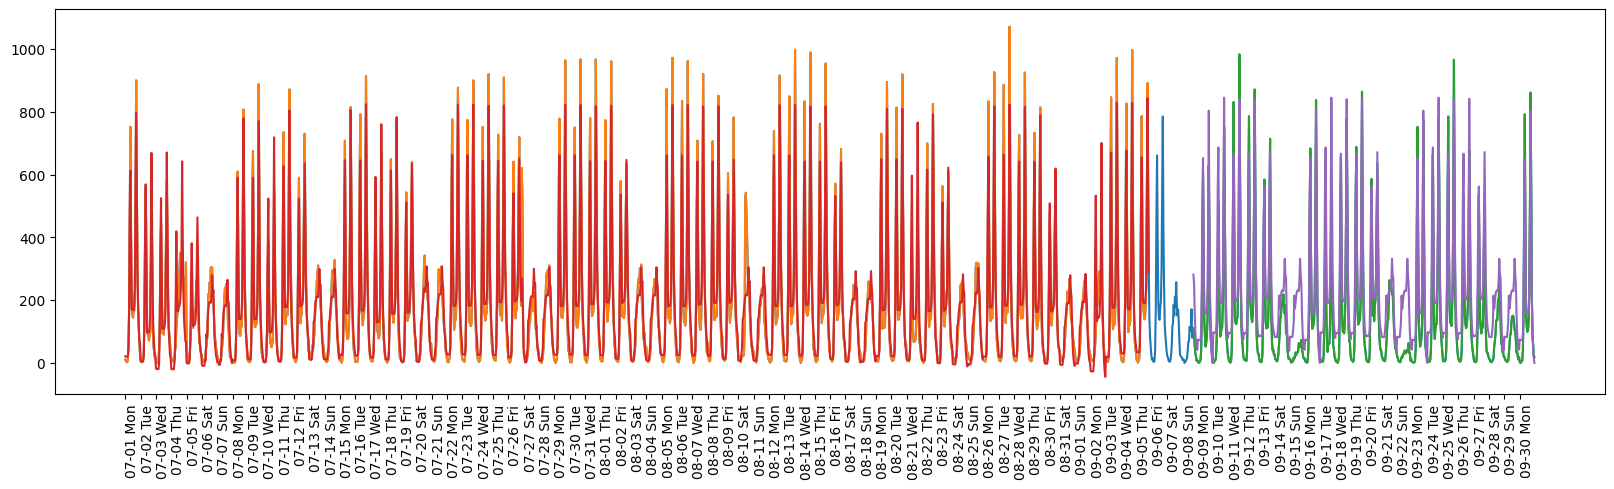

In [26]:
plt.figure(figsize=(20, 5))

### исходные данные

xticks = pd.date_range(start = dfc.index.min(), end=dfb.index.max(),freq='D')
x_range = [dfc.index.get_loc(t) for t in xticks]

plt.xticks(x_range, xticks.strftime("%m-%d %a"), rotation=90, ha="left")

# все истина
plt.plot(range(len(X)), y, label="all")
# тренировка истина
plt.plot(range(len(X_train)), y_train, label="train")
# тест истина
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_test, label="train");

# тренировка predict
plt.plot(range(len(X_train)), y_train_predict, label="train predict")

# тренировка predict
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_predict, label="predict");

## Создадим свой трансформер

In [27]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

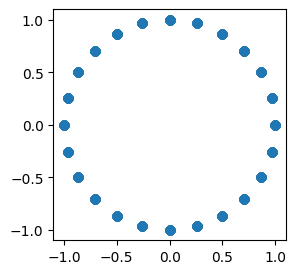

In [28]:
plt.figure(figsize=(3, 3))
sin_df = sin_transformer(24).fit_transform(dfc)["hour"]
cos_df  = cos_transformer(24).fit_transform(dfc)["hour"]
plt.scatter(sin_df, cos_df);

In [29]:
### Исполнителю реализовавшему трансформеры на 24 часа, на 12 месяцев + рабочие/выходные дни -  
### доп.балл (конечно если будет FunctionTransformer )